In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
from scipy.fft import fft
from scipy.signal import spectrogram

In [37]:
# Fourier Transform function
def compute_fourier_transform(signal, sampling_rate):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(fft(signal))
    return freq[:n // 2], fft_values[:n // 2]  # Only positive frequencies

In [38]:
# Wavelet Decomposition function
def wavelet_decomposition(signal, wavelet, levels):
    coeffs = pywt.wavedec(signal, wavelet, level=levels)
    return coeffs  # Coefficients for each level

In [39]:
# Spectrogram function
def compute_spectrogram(signal, sampling_rate):
    f, t, Sxx = spectrogram(signal, fs=sampling_rate)
    return f, t, Sxx

In [40]:
# Main function to extract and analyze frequency domain features
def process_frequency_features(data_path, classes, wavelet='db4', levels=4, sampling_rate=256):
    results = []

    for class_name in classes:
        class_folder = os.path.join(data_path, class_name)
        samples = os.listdir(class_folder)[:1]  # Select the first sample for demonstration

        for sample_id, sample_file in enumerate(samples):
            sample_path = os.path.join(class_folder, sample_file)
            data = np.load(sample_path)  # Assuming data is saved as .npy file

            output_folder = f"frequency_features/class_{class_name}_sample_{sample_id}"
            os.makedirs(output_folder, exist_ok=True)

            for channel_idx in range(data.shape[0]):
                signal = data[channel_idx]

                # Fourier Transform
                freq, fft_values = compute_fourier_transform(signal, sampling_rate)
                plt.figure()
                plt.plot(freq, fft_values)
                plt.title(f"Fourier Transform - Channel {channel_idx + 1}")
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Amplitude")
                plt.savefig(f"{output_folder}/channel_{channel_idx + 1}_fourier.png")
                plt.close()

                # Wavelet Decomposition
                coeffs = wavelet_decomposition(signal, wavelet, levels)
                for level, coeff in enumerate(coeffs):
                    plt.figure()
                    plt.plot(coeff)
                    plt.title(f"Wavelet Coefficients (Level {level}) - Channel {channel_idx + 1}")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.savefig(f"{output_folder}/channel_{channel_idx + 1}_wavelet_level_{level}.png")
                    plt.close()

                # Spectrogram
                f, t, Sxx = compute_spectrogram(signal, sampling_rate)
                plt.figure()
                plt.pcolormesh(t, f, 10 * np.log10(Sxx))
                plt.title(f"Spectrogram - Channel {channel_idx + 1}")
                plt.xlabel("Time (s)")
                plt.ylabel("Frequency (Hz)")
                plt.colorbar(label="Power/Frequency (dB/Hz)")
                plt.savefig(f"{output_folder}/channel_{channel_idx + 1}_spectrogram.png")
                plt.close()

                # Collect results for presentation
                results.append({
                    "Class": class_name,
                    "Sample": sample_id,
                    "Channel": f"Channel {channel_idx + 1}",
                    "Fourier Transform": f"{output_folder}/channel_{channel_idx + 1}_fourier.png",
                    "Spectrogram": f"{output_folder}/channel_{channel_idx + 1}_spectrogram.png",
                    "Wavelet Coefficients": [
                        f"{output_folder}/channel_{channel_idx + 1}_wavelet_level_{level}.png"
                        for level in range(len(coeffs))
                    ]
                })

    return results


KeyboardInterrupt: 

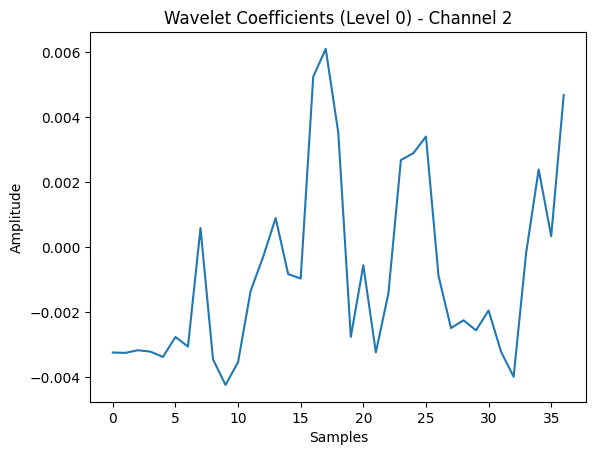

In [41]:
# Path to the data folder and class names
data_path = r"C:/Users/User/Desktop/Hackathon/Impulse/noisy_train_data"  # Update this path
classes = ["Complex_Partial_Seizures", "Electrographic_Seizures", "Normal", "Video_detected_Seizures_with_no_visual_change_over_EEG"]

# Process data and extract frequency features
frequency_features = process_frequency_features(data_path, classes)

# Save frequency features overview to CSV
frequency_features_df = pd.DataFrame(frequency_features)
os.makedirs("output", exist_ok=True)
frequency_features_csv_path = os.path.join("output", "frequency_features_overview.csv")
frequency_features_df.to_csv(frequency_features_csv_path, index=False)

print(f"Frequency features overview saved to {frequency_features_csv_path}")


In [50]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pywt
from scipy.signal import spectrogram, find_peaks
import pandas as pd



In [51]:
# Define paths and parameters
data_folder = "C:/Users/User/Desktop/Hackathon/Impulse/noisy_train_data"  # Path to .npy files
output_folder = "output/"  # Path to save outputs
os.makedirs(output_folder, exist_ok=True)  # Create output folder if not exists
fs = 256  # Sampling frequency (Hz)


In [52]:
# Function to compute Fourier Transform features
def compute_fourier_features(signal):
    N = len(signal)
    fft_values = fft(signal)
    fft_magnitude = np.abs(fft_values[:N // 2])  # Magnitude of FFT (one-sided)
    fft_freq = np.fft.fftfreq(N, d=1/fs)[:N // 2]  # Corresponding frequencies

    mean_frequency = np.sum(fft_freq * fft_magnitude) / np.sum(fft_magnitude)
    median_frequency = fft_freq[np.argsort(fft_magnitude)[len(fft_magnitude) // 2]]
    power_spectral_density = np.sum(fft_magnitude ** 2) / N

    return fft_freq, fft_magnitude, mean_frequency, median_frequency, power_spectral_density

In [54]:

# Function to compute Zero Crossing Rate
def compute_zero_crossing_rate(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zcr = len(zero_crossings) / len(signal)
    return zcr

In [55]:
# Function to perform wavelet decomposition
def wavelet_decomposition(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approx_coeffs = coeffs[0]
    detail_coeffs = coeffs[1:]
    return approx_coeffs, detail_coeffs

In [56]:
# Process each file and extract features
classes = os.listdir(data_folder)
features_list = []

for class_name in classes:
    class_path = os.path.join(data_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    file_list = [f for f in os.listdir(class_path) if f.endswith('.npy')]
    print(f"Processing class '{class_name}' with {len(file_list)} files...")

    for file_name in file_list:
        file_path = os.path.join(class_path, file_name)
        signal_data = np.load(file_path)  # Load the .npy file

        for channel_idx, channel_signal in enumerate(signal_data):
            # Compute Fourier features
            fft_freq, fft_magnitude, mean_freq, median_freq, psd = compute_fourier_features(channel_signal)

            # Compute Zero Crossing Rate
            zcr = compute_zero_crossing_rate(channel_signal)

            # Perform Wavelet Decomposition
            approx_coeffs, detail_coeffs = wavelet_decomposition(channel_signal)

            # Save features for this channel
            features = {
                'class': class_name,
                'file': file_name,
                'channel': channel_idx,
                'zcr': zcr,
                'fft_mean': np.mean(fft_magnitude),
                'fft_std': np.std(fft_magnitude),
                'mean_freq': mean_freq,
                'median_freq': median_freq,
                'psd': psd,
                'approx_mean': np.mean(approx_coeffs),
                'approx_std': np.std(approx_coeffs)
            }

            for level, detail in enumerate(detail_coeffs, start=1):
                features[f'detail{level}_mean'] = np.mean(detail)
                features[f'detail{level}_std'] = np.std(detail)

            features_list.append(features)

Processing class 'Complex_Partial_Seizures' with 2196 files...
Processing class 'Electrographic_Seizures' with 545 files...
Processing class 'Normal' with 2783 files...
Processing class 'Video_detected_Seizures_with_no_visual_change_over_EEG' with 84 files...


In [57]:
# Convert extracted features to a DataFrame
features_df = pd.DataFrame(features_list)
features_csv_path = os.path.join(output_folder, 'extracted_features_noisytraindata.csv')
features_df.to_csv(features_csv_path, index=False)
print(f"Extracted features saved to {features_csv_path}")

Extracted features saved to output/extracted_features_noisytraindata.csv


In [58]:
# Example: Generate and save a spectrogram for a channel
example_signal = signal_data[0]  # Example: First channel of the first file
frequencies, times, Sxx = spectrogram(example_signal, fs)
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
spectrogram_path = os.path.join(output_folder, 'example_spectrogram.png')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.savefig(spectrogram_path)
plt.close()
print(f"Spectrogram saved to {spectrogram_path}")

Spectrogram saved to output/example_spectrogram.png
